In [1]:
kgp_yr = 1951
chl_yr = 2006
sst_yr = 1950

In [2]:
from itertools import product

import numpy as np
import xarray as xr
import pandas as pd
from scipy import integrate

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util
plt.style.use('ggplot')

In [3]:
variables = ['SST', 'Chl_surf', 'KGP']

ds_djf = xr.open_zarr('data/cesm-le-djf-triregion-timeseries.zarr')
ds_djf = ds_djf[variables].sel(length = 40).sel(region = 'Southern Ocean')
ds_djf

<xarray.Dataset>
Dimensions:    (member_id: 34, time: 180)
Coordinates:
    region     <U17 'Southern Ocean'
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    length     float64 40.0
Data variables:
    SST        (time, member_id) float64 dask.array<chunksize=(180, 34), meta=np.ndarray>
    Chl_surf   (time, member_id) float64 dask.array<chunksize=(180, 34), meta=np.ndarray>
    KGP        (time, member_id) float64 dask.array<chunksize=(90, 34), meta=np.ndarray>

## Look at the data
#### Compute the properties of the unperturbed climate

The mean

In [4]:
ds_ref_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
#ds_ref_mean

Standard deviation of anomalies

In [5]:
ds_ref_std = (
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id'])
        .compute()
)
#ds_ref_std

### calculate and plot the anomalies relative to the reference

In [6]:
forced = ds_djf.mean('member_id')     
anom_f = forced - ds_ref_mean
#anom_f

Text(0.5, 1.0, 'Daily growth rate anomaly ')

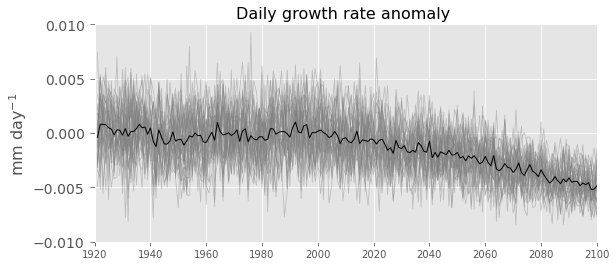

In [7]:
v = 'KGP'
###########   As a Plot  ##############
gs = gridspec.GridSpec(1,1)
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
limYMin, limYMax = -0.01, 0.01
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf.member_id:
    var_i = ds_djf[v].sel(member_id=m_id)
    ref_i = ds_djf[v].sel(member_id=m_id).sel(time=slice('1920', '1950')).mean(['time'])
    anom = var_i - ref_i
    ax.plot(ds_djf.time, anom,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='k')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(f'{ds_djf[v].long_name} anomaly ', fontsize = 16)

In [8]:
#subset data for the time-period of this trend
ds_cc_k = ds_djf.sel(time=slice(kgp_yr, 2021))

ds_cc_c = ds_djf.sel(time=slice(chl_yr, 2021))

ds_cc_t = ds_djf.sel(time=slice(sst_yr, 2021))
ds_cc_t



<xarray.Dataset>
Dimensions:    (member_id: 34, time: 72)
Coordinates:
    region     <U17 'Southern Ocean'
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) int64 1950 1951 1952 1953 1954 ... 2018 2019 2020 2021
    length     float64 40.0
Data variables:
    SST        (time, member_id) float64 dask.array<chunksize=(72, 34), meta=np.ndarray>
    Chl_surf   (time, member_id) float64 dask.array<chunksize=(72, 34), meta=np.ndarray>
    KGP        (time, member_id) float64 dask.array<chunksize=(61, 34), meta=np.ndarray>

In [25]:
def dataset_encoding(xds):
    cols = ['source', 'original_shape', 'dtype', 'zlib', 'complevel', 'chunksizes']
    info = pd.DataFrame(columns=cols, index=xds.data_vars)
    for row in info.index:
        var_encoding = xds[row].encoding
        for col in info.keys():
            info.ix[row, col] = var_encoding.pop(col, '')
    
    return info


def xarray_trend(xarr):    
    from scipy import stats
    # getting shapes
    
    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]
    
    # creating x and y variables for linear regression
    x = xarr.time.values[:, None]     #time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)
    
    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly
    
    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)
    
    # misclaneous additional functions
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5
    
    # preparing outputs
    out = xarr[:2].mean('time')
    # first create variable for slope and adjust meta
    xarr_slope = out.copy()
    xarr_slope.name += '_slope'
    xarr_slope.attrs['units'] = 'units / day'
    xarr_slope.values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    xarr_p = out.copy()
    xarr_p.name += '_Pvalue'
    xarr_p.attrs['info'] = "If p < 0.05 then the results from 'slope' are significant."
    xarr_p.values = p.reshape(xarr.shape[1:])
    # join these variables
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p

    return xarr_out


In [26]:
test = xarray_trend(ds_cc_k['KGP'].mean('member_id'))
test

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    region   <U17 'Southern Ocean'
    length   float64 40.0
Data variables:
    slope    float64 -2.011e-06
    pval     float64 0.2358

In [27]:
def xarray_trend(xarr):    
    from scipy import stats
    # getting shapes
    
    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]
    
    # creating x and y variables for linear regression
    x = xarr.time.values[:, None]     #time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)
    
    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly
    
    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)
    
    # misclaneous additional functions
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5
    
    # preparing outputs
    out = xarr[:2].mean('time')
    # first create variable for slope and adjust meta
    xarr_slope = out.copy()
    xarr_slope.name += '_slope'
    xarr_slope.attrs['units'] = 'units / day'
    xarr_slope.values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    xarr_p = out.copy()
    xarr_p.name += '_intercept'
    xarr_p.attrs['info'] = "intercept = ym - (slope * xm)"
    xarr_p.values = intercept.reshape(xarr.shape[1:])
    # join these variables
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['intercep'] = xarr_p

    return xarr_out


In [28]:
test2 = xarray_trend(ds_cc_k['KGP'].mean('member_id'))
test2

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    region    <U17 'Southern Ocean'
    length    float64 40.0
Data variables:
    slope     float64 -2.011e-06
    intercep  float64 0.01354

In [30]:
b = 0.01354
m = -2.011e-06
x = ds_cc_k.time.values

y = m * x + b

ValueError: x and y must have same first dimension, but have shapes (180,) and (71,)

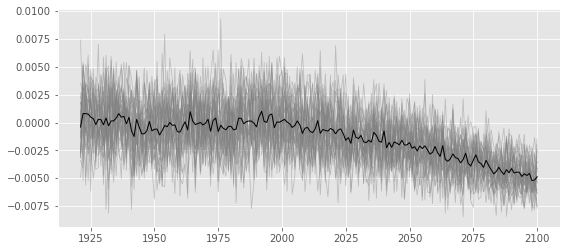

In [31]:
v = 'KGP'
###########   As a Plot  ##############
gs = gridspec.GridSpec(1,1)
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(gs[0, 0])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf.member_id:
    var_i = ds_djf[v].sel(member_id=m_id)
    ref_i = ds_djf[v].sel(member_id=m_id).sel(time=slice('1920', '1950')).mean(['time'])
    anom = var_i - ref_i
    ax.plot(ds_djf.time, anom,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='k')

for year in ds_djf.time:
    b = 0.01354
    m = -2.011e-06
    x = ds_cc_k.time.values
    y = m * x + b
    ax.plot(ds_djf.time, y,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_xlim((1920, 2100))
limYMin, limYMax = -0.01, 0.01
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(f'{ds_djf[v].long_name} anomaly ', fontsize = 16)

In [ ]:
def prospective_trends():


    
    # set up trend dimensions
    trend_year = xr.DataArray([1950, 1951], dims=('time'))
#    trend_length = xr.DataArray([5, 10, 20, 50], dims=('trend_length'))

    # loop over trends
    ds_list = []
    for start_year, n_year in product(trend_year.values, trend_length.values):

        # subset data for the time-period of this trend
        ds = ds_djf.sel(time=slice(start_year, start_year+n_year-1))
        if len(ds.time) != n_year: 
            continue

        # loop over vars and compute trends
        da_list = []
        for v in ds.data_vars:
            da = util.linear_trend(
                ds[v]
            ).expand_dims(
                trend_length=[n_year], 
                trend_year=[start_year]
            ) * 10.
            da.attrs = ds[v].attrs
            da.attrs['units'] = ds[v].units + ' decade$^{-1}$'
            da_list.append(da)
            
        ds_list.append(xr.merge(da_list))

    return xr.combine_by_coords(ds_list) #.compute()

ds = prospective_trends()
ds

In [ ]:
v = 'KGP'
###########   As a Plot  ##############
gs = gridspec.GridSpec(1,1)
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(gs[0, 0])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf.member_id:
    var_i = ds_djf[v].sel(member_id=m_id)
    ref_i = ds_djf[v].sel(member_id=m_id).sel(time=slice('1920', '1950')).mean(['time'])
    anom = var_i - ref_i
    ax.plot(ds_djf.time, anom,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='k')

ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='k')


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_xlim((1920, 2100))
limYMin, limYMax = -0.01, 0.01
ax.set_ylim([limYMin, limYMax])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(f'{ds_djf[v].long_name} anomaly ', fontsize = 16)